In [2]:
import io
import os
import sys
import gensim.models.word2vec as w2v 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 	
from matplotlib import pyplot

In [84]:
with io.open("Span-Eng.txt", "r", encoding="utf-8") as f: 
    sentences = [line.strip("\n").split("|") for line in f]

In [85]:
sentences[:10]

[['oh', 'eng'],
 [',', 'punct'],
 ['no', 'eng'],
 ['.', 'punct'],
 ['i', 'eng'],
 ['am', 'eng'],
 ['not', 'eng'],
 ['gonna', 'eng'],
 ['take', 'eng'],
 ['her', 'eng']]

In [86]:
x = []
y = []
i = 0
while i in range(len(sentences)): 
    x.append(sentences[i][0])
    y.append(sentences[i][1])
    i += 1

In [87]:
token_count = sum([len(line) for line in x])
print("The  corpus contains {0:,} tokens".format(token_count))

The  corpus contains 25,963 tokens


In [27]:
Embeddings = w2v.Word2Vec(x, min_count=0, size=300, window=1, workers=15, sample=0.0001)

In [29]:
word_list = [x.split() for x in x]

In [32]:
Embeddings = w2v.Word2Vec(word_list, min_count=2, size=300, window=1, workers=15, sample=0.0001)



In [33]:
print("Embeddings vocabulary length:", len(Embeddings.wv.vocab))



Embeddings vocabulary length: 604


In [34]:
Embeddings.save("Spanglish.w2v")

In [35]:
X = Embeddings[Embeddings.wv.vocab]

In [36]:
pca = PCA(n_components=2)

In [37]:
result = pca.fit_transform(X)

In [38]:
pyplot.scatter(result[:, 0], result[:, 1])

In [39]:
words = list(Embeddings.wv.vocab)

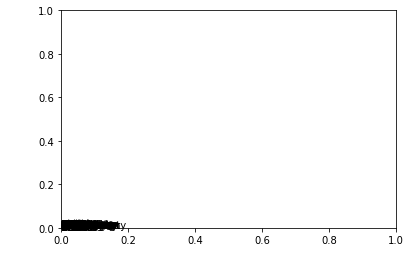

In [41]:
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [88]:
import sys, io
import numpy as np
from gensim.models import Word2Vec
import keras.utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Dense, LSTM, Dropout, Activation, TimeDistributed, Flatten
from keras.models import Model, Sequential
from keras import optimizers
from pyexcel_xlsx import get_data

In [89]:
EMBEDDING_DIM = 300
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH=100
VALIDATION_SPLIT = 0.3

In [90]:
texts = []
documents = []
labels = []
labels_index = {}
ind = 0

In [91]:
x[43]

'podemos'

In [92]:
y[43]

'span'

In [93]:
print("tokenizing")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(x)#texts
sequences = tokenizer.texts_to_sequences(x)#texts

tokenizing


In [94]:
#load pre-trained word embeddings 
gensimemb = Word2Vec.load('Spanglish.w2v')
embedding_matrix = np.zeros((len(gensimemb.wv.vocab), EMBEDDING_DIM))
for i in range(len(gensimemb.wv.vocab)):
    embvec = gensimemb.wv[gensimemb.wv.index2word[i]]
    if embvec is not None:
        embedding_matrix[i] = embvec

In [95]:
word_index = tokenizer.word_index
print('found %s unique tokens.' % len(word_index))
print("padding")
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

found 1287 unique tokens.
padding


In [96]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
print('Encoding labels...')
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
labels = integer_encoded

Encoding labels...


In [97]:
from keras.utils import np_utils
labels = keras.utils.to_categorical(labels)

In [100]:
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
print('Data shuffled and split')

Data shuffled and split


In [107]:
weight_decay = 0

from keras.layers.normalization import BatchNormalization
from keras.layers.core import *
from keras.regularizers import l2
regularizer = l2(weight_decay) if weight_decay else None

TOTAL_WORDS, EMBEDDING_DIM = embedding_matrix.shape

EPOCHS = 5
BATCHSIZE = 128
OUTPUTDIM = 5
#optimizer
adam = optimizers.Adam(lr=0.9, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
print ("Building Model...")
embedding_layer = Embedding(TOTAL_WORDS,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix], mask_zero=True,
                            input_length=MAX_SEQUENCE_LENGTH,W_regularizer=regularizer,
                            trainable=True, embeddings_initializer="glorot_uniform")
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedded_sequences = embedding_layer(sequence_input)
x = LSTM(128,activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
         recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True )(embedded_sequences) # <- 128 = num_hidden_nodes
x = BatchNormalization()(x)
x = Activation('sigmoid')(x)
x = Dropout(0.5)(x)
x = LSTM(64)(embedded_sequences)
x = Dropout(0.2)(x)
preds = Dense(OUTPUTDIM, activation='softmax')(x) #hyperas
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print ("Training...")
history = model.fit(x_train, y_train,
                    batch_size=BATCHSIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_split=0.2)

Building Model...


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(604, 300, embeddings_initializer="glorot_uniform", mask_zero=True, trainable=True, input_length=100, weights=[array([[ ..., embeddings_regularizer=None)`


Training...


ValueError: Error when checking target: expected dense_9 to have shape (None, 5) but got array with shape (5608, 4)

In [68]:
# Converts the labels to a one-hot representation
import numpy as np
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

NameError: name 'y_train' is not defined

In [70]:
# Split data into train and test
train_size = int(len(x) * .7)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(x) - train_size))

Train size: 5607
Test size: 2404


In [75]:
xtrain = data[:train_size]
xtest = data[train_size:]
ytrain = y_new[:train_size]
ytest = y_new[train_size:]

In [79]:
weight_decay = 0
from keras.layers.normalization import BatchNormalization
from keras.layers.core import *
from keras.regularizers import l2
regularizer = l2(weight_decay) if weight_decay else None

TOTAL_WORDS, EMBEDDING_DIM = embedding_matrix.shape

EPOCHS = 5
BATCHSIZE = 128
OUTPUTDIM = 5
#optimizer
adam = optimizers.Adam(lr=0.9, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
print ("Building Model...")
embedding_layer = Embedding(TOTAL_WORDS,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix], mask_zero=True,
                            input_length=MAX_SEQUENCE_LENGTH,W_regularizer=regularizer,
                            trainable=True, embeddings_initializer="glorot_uniform")
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedded_sequences = embedding_layer(sequence_input)
x = LSTM(128,activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
         recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True )(embedded_sequences) # <- 128 = num_hidden_nodes
x = BatchNormalization()(x)
x = Activation('sigmoid')(x)
x = Dropout(0.5)(x)
x = LSTM(64)(embedded_sequences)
x = Dropout(0.2)(x)
preds = Dense(OUTPUTDIM, activation='softmax')(x) #hyperas
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print ("Training...")
model.fit(xtrain, ytrain, validation_split=0.2, epochs=EPOCHS, batch_size=BATCHSIZE)

Building Model...


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(604, 300, embeddings_initializer="glorot_uniform", mask_zero=True, trainable=True, input_length=100, weights=[array([[ ..., embeddings_regularizer=None)`


Training...


ValueError: Error when checking target: expected dense_2 to have shape (None, 5) but got array with shape (5607, 1)